# Exploration and Data Collection

In this notebook, the first stage of initial data-exploration is carried out:

* We count time phrases in the Hebrew Bible and see which ones are the most common.
* We make counts of the verb tenses and their percentages as used within single time phrase markers.
* Finally, we export a dataset with pickle for processing in further notebooks.

This notebook finds some initial corrolations between certain time phrases and the tenses used alongside them. See the interesting comparison between the phrase עד היום הזה (wayyiqtol prominent!) and עד עולם (yiqtol prominent). Other time markers also prefer yiqtol over wayyiqtol or vice versa.

In [1]:
# import tools
import collections, matplotlib, pickle
import pandas as pd
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from pprint import pprint

from tf.fabric import Fabric

In [2]:
# initialize and load TF and data

TF = Fabric(modules='hebrew/etcbc4c', silent=True)

api = TF.load('''
                language book chapter verse
                g_cons lex
                function vt kind pdp typ
                mother tab domain code
              ''')

api.makeAvailableIn(globals())

  0.00s loading features ...
   |     0.01s B book                 from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.00s B chapter              from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.01s B verse                from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.14s B g_cons               from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.12s B language             from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.14s B lex                  from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.09s B function             from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.20s B vt                   from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.03s B kind                 from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.16s B pdp                  from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.29s B typ           

In [3]:
# import custom function for weqetal detection
from functions.verbs import is_weqt

## Clause Level: Tense and Time Markers

Before gathering data at the text level for verbal tense, we will look for tendencies at the clause level. It is intended that the information gathered at clause level can be compared with that from the text level, which in turn can help with the question of whether tense selection can really be influenced by a time marker in another clause. In other words, if the same kinds of tendencies that affect the verbal tense at clause level appear at text level, the case for "time spans" is strengthened.

We begin with some preliminary data-exploration.

## 1. Survey Time Markers in Verbal Clauses

How many different time markers appear in verbal clauses? What are the most common ones? How diverse are they?

In [4]:
# count time markers
time_markers = collections.defaultdict(list)

# count clauses with multiple time markers
multiples = []

# get time markers from clauses
for clause in F.otype.s('clause'):
    
    # skip clause if not Hebrew
    language = F.language.v(L.d(clause, otype='word')[0])
    if language != 'hbo':
        continue
    
    # skip clause if not verbal
    if F.kind.v(clause) != 'VC':
        continue
        
    times = [time_phrase for time_phrase in L.d(clause, otype='phrase')
                if F.function.v(time_phrase) == 'Time']
    
    # skip clause if there are no time phrases
    if not times:
        continue
        
    # treat multiple time markers separately
    if len(times) > 1:
        multiples.append(clause)
        
    # measure and save other time markers
    else:
        
        # isolate time marker
        marker = times[0]
        
        # get plain-text for the time marker
        consonantal_words = tuple(F.g_cons.v(word) for word in L.d(marker, otype='word'))
        marker_text = ' '.join(consonantal_words)
        
        # save marker and clause node
        time_markers[marker_text].append(clause)
        
# make/present counts

# keep count here
initial_counts = collections.Counter()

# count them
for marker, clause_list in time_markers.items():
    initial_counts[marker] += len(clause_list)
    
# various counts  
top_markers = initial_counts.most_common(50)
top_total = sum(count for marker, count in top_markers)
init_counts_total = sum(initial_counts.values())
    
# put counts into pandas dataframe

initial_dataframe = pd.DataFrame(top_markers, columns=('Markers', 'Counts'))

print('Clauses with single marker: ', init_counts_total)
print('Clauses with multiple markers: ', len(multiples))

Clauses with single marker:  3102
Clauses with multiple markers:  109


In [5]:
print('total top 50: ', top_total)
print('\t\t({}% of all...)'.format(round(top_total/init_counts_total, 2) * 100))
print('total types: ', len(initial_counts.keys()))

initial_dataframe

total top 50:  1651
		(53.0% of all...)
total types:  985


,Markers,Counts
0,B JWM H HW>,198
1,H JWM,160
2,<TH,78
3,B BQR,76
4,L <WLM,76
5,<D H JWM H ZH,58
6,>Z,57
7,CB<T JMJM,56
8,B JWM,53
9,<D <WLM,45


Notes:

1. prepositions denoting position: e.g. <D, B, L, M, >XR, >Z
2. nouns denoting time/event: JWM, <TH, BQR, <WLM, <RB, MXR, LJLH, 
3. words denoting quantity: KL, numbers
4. word denoting extent: <D
5. the role of article/demonstratives in indicating distance: H, ZH, HW>, HM, HJ>

## 2. Corrolate Time Markers with Verb Tense

Now we take the registered time markers in the `time_markers` dict and use the list values (which contain the clause node numbers) to gather verb tense statistics. 

In [6]:
def get_verb(clause):
    '''
    Extract and return a word node 
    that functions as the primary verb.
    Require a clause node.
    '''

    # set of predicative phrase functions
    # derived from a small query
    predicates = {'Pred', 'PreO', 'PreS','PreC','PtcO'}

    # get the main verb
    verb = [word for phrase in L.d(clause, otype='phrase')
                for word in L.d(phrase, otype='word')

                 # phrase must be predicate; word functions as verb
                 if F.function.v(phrase) in predicates
                    and F.pdp.v(word) == 'verb'
            ]

    # account for clauses with both Pred and PreC, take only Pred
    if len(verb) > 1:
        verb = [word for word in verb 
                    if F.function.v(L.u(word, otype='phrase')[0]) == 'Pred']

    return verb[0]

### 2.1. Count Tenses and Sort Clause Lists by Tenses/Time Markers

In [7]:
# hold verbs & verb stats here
tense_counts = collections.defaultdict(lambda: collections.Counter())
tenses = collections.defaultdict(lambda: collections.defaultdict(list))

# count verbs
for time_marker, clause_list in time_markers.items():
    
    for clause in clause_list:

        verb = get_verb(clause)
        
        # get the verb's tense
        tense = F.vt.v(verb)
        
        # register weqetal separately from qatal
        tense = 'weqt' if is_weqt(verb) else tense
        
        # save the data to the time marker key
        tense_counts[time_marker][tense] += 1
        tense_counts[time_marker]['total'] += 1
        
        # save the clause under its corresponding verb tense
        tenses[time_marker][tense].append(clause) 
        
print('done with counts...\n')

done with counts...



In [8]:
pprint(tenses['L NYX'])

defaultdict(<class 'list'>,
            {'impf': [457153,
                      468108,
                      469177,
                      469638,
                      471993,
                      473060,
                      478514,
                      486101,
                      489450,
                      491248,
                      491432,
                      491614,
                      492313,
                      493112,
                      493644,
                      494187,
                      496701,
                      497404,
                      497747,
                      497993],
             'perf': [468898, 489414, 489497, 492876]})


In [9]:
# make percentage counts for all time markers and their verbs

# get all the tenses to fill in zero counts
all_tenses = sorted(tense for tense, value in F.vt.freqList())
all_tenses.remove('NA') # don't count this
all_tenses.append('weqt') # add custom weqetal tense

# put the percentage counts here
tense_percentages = {}

# make % counts based on verb_counts
for time_marker, counts in tense_counts.items():
    
    # make percentage counts; exclude "total" from percentage counts
    total = counts['total']
    percentages = dict((tense, (count/total)*100) for tense, count in counts.items()
                          if tense != 'total'
                      )
    
    # fill in any empty tense slots
    all_percentages = dict((tense, percentages.get(tense, 0)) for tense in all_tenses)
    
    # save the count
    tense_percentages[time_marker] = all_percentages

# check results
print(len(tense_percentages), 'percentages counted\n')
print('Sample: ')
pprint(tense_percentages['>Z'])

985 percentages counted

Sample: 
{'impf': 68.42105263157895,
 'impv': 0,
 'infa': 0,
 'infc': 0,
 'perf': 29.82456140350877,
 'ptca': 1.7543859649122806,
 'ptcp': 0,
 'wayq': 0,
 'weqt': 0}


In [10]:
# fill in any blank slots for verb counts and verbs (counts, not percentages)

# counts
for marker, counts in tense_counts.items():
    counts = dict((tense, counts.get(tense, 0)) for tense in all_tenses)
    tense_counts[marker] = counts
    
# verbs
for marker, tense_dict in tenses.items():
    tense_dict = dict((tense, tense_dict.get(tense, [])) for tense in all_tenses)
    tenses[marker] = tense_dict
    
print('Sample:')
pprint(tense_counts['L NYX'])
print()
pprint(tenses['L NYX'])

Sample:
{'impf': 20,
 'impv': 0,
 'infa': 0,
 'infc': 0,
 'perf': 4,
 'ptca': 0,
 'ptcp': 0,
 'wayq': 0,
 'weqt': 0}

{'impf': [457153,
          468108,
          469177,
          469638,
          471993,
          473060,
          478514,
          486101,
          489450,
          491248,
          491432,
          491614,
          492313,
          493112,
          493644,
          494187,
          496701,
          497404,
          497747,
          497993],
 'impv': [],
 'infa': [],
 'infc': [],
 'perf': [468898, 489414, 489497, 492876],
 'ptca': [],
 'ptcp': [],
 'wayq': [],
 'weqt': []}


### 3. Analyze Initial Results with Visualizations

In [11]:
# Collect/display stats
    
# a header for the pandas table
header = ['marker', 'occur'] + all_tenses

# holds rows for the table
stats_rows = []

# to reproduce row data for later visualizations
stats_dict = {'header': header}

# display the counts using top 50 order
for marker, count in initial_counts.items():

    count = initial_counts[marker]
    
    # collect percentages/counts in sorted order of tense name
    percentages = ['{}%'.format(round(count, 1)) for tense, count 
                       in sorted(tense_percentages[marker].items())]
    
    counts = [count for tense, count in sorted(tense_counts[marker].items())]
    
    # combine percentages/stats into individual strings
    stats = ['{} ({})'.format(percent, count) for percent, count in zip(percentages, counts)]
    
    row = [marker, count] + stats
    
    # add row data
    
    # add only top 50 for this display
    if (marker, count) in top_markers:
        stats_rows.append((count, row))
    
    # add all row data for later
    stats_dict[marker] = row
    

# get sorting for visualization below
sort_top_rows = [row[1] for row in sorted(stats_rows, reverse=True)]
    
verb_counts_df = pd.DataFrame(sort_top_rows, columns=header)

In [12]:
verb_counts_df

,marker,occur,impf,impv,infa,infc,perf,ptca,ptcp,wayq,weqt
0,B JWM H HW>,198,29.3% (58),0% (0),0% (0),0.5% (1),14.1% (28),2.0% (4),0% (0),31.8% (63),22.2% (44)
1,H JWM,160,15.0% (24),3.8% (6),0% (0),5.0% (8),35.0% (56),30.0% (48),0% (0),7.5% (12),3.8% (6)
2,<TH,78,50.0% (39),9.0% (7),0% (0),0% (0),37.2% (29),1.3% (1),2.6% (2),0% (0),0% (0)
3,L <WLM,76,60.5% (46),3.9% (3),0% (0),7.9% (6),11.8% (9),3.9% (3),2.6% (2),2.6% (2),6.6% (5)
4,B BQR,76,13.2% (10),10.5% (8),1.3% (1),3.9% (3),2.6% (2),3.9% (3),0% (0),55.3% (42),9.2% (7)
5,<D H JWM H ZH,58,5.2% (3),0% (0),0% (0),1.7% (1),29.3% (17),3.4% (2),0% (0),60.3% (35),0% (0)
6,>Z,57,68.4% (39),0% (0),0% (0),0% (0),29.8% (17),1.8% (1),0% (0),0% (0),0% (0)
7,CB<T JMJM,56,46.4% (26),1.8% (1),0% (0),0% (0),1.8% (1),0% (0),0% (0),19.6% (11),30.4% (17)
8,B JWM,53,30.2% (16),3.8% (2),0% (0),3.8% (2),41.5% (22),0% (0),0% (0),15.1% (8),5.7% (3)
9,<D <WLM,45,48.9% (22),2.2% (1),0% (0),11.1% (5),6.7% (3),6.7% (3),0% (0),4.4% (2),20.0% (9)


### 3.1. Some Interesting Results

Both of the following time markers begin with the preposition עד, but one is *wayyiqtol* predominant and the other is *yiqtol* predominant.

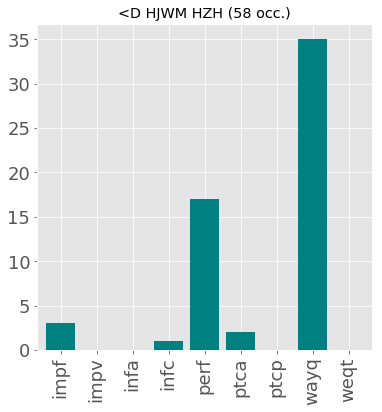

In [13]:
# put tense/counts into dataframe for plotting
until_today = pd.Series(tense_counts['<D H JWM H ZH'], index=all_tenses)
until_forever = pd.Series(tense_counts['<D <WLM'], index=all_tenses)

# display plot
until_today.plot.bar(figsize=(6,6), 
                       color='teal', 
                       width = .8,
                       fontsize=18,
                       title='<D HJWM HZH (58 occ.)'
                    )

# save to file
plt.savefig('visualizations/until_today.png', dpi = 300)

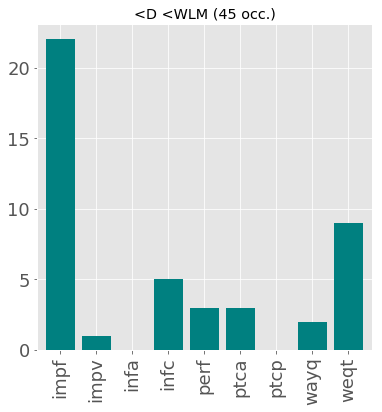

In [14]:
# display plot
until_forever.plot.bar(figsize=(6,6), 
                       color='teal', 
                       width=.8,
                       fontsize=18,
                       title='<D <WLM (45 occ.)'
                      )
# save to file
plt.savefig('visualizations/until_forever.png', dpi = 300)

## 4. Export Data

This data, especially the full table/counts above, provides an apt starting point for further lines of questioning. But much more inquiry is required to determine what factors play a role in determining a time marker's tense. The data is gathered together into a single dict for further analysis in other notebooks. 

In [15]:
# put all export data here
time_marker_data = {'markers':{}}

# keep top markers dict
time_marker_data['top_markers'] = top_markers

# keep the stats rows
time_marker_data['stats_rows'] = stats_dict

# assemble data from various dicts in this notebook
for marker, clause_list in time_markers.items():
    
    # retrieve
    count = len(clause_list)
    tense_to_clause = tenses[marker]
    tense_cts = tense_counts[marker]
    tense_pct = tense_percentages[marker]
    #representative time marker – allows for preposition search, etc. with TF objs
    example_phrase = [phr for phr in L.d(clause_list[0]) if F.function.v(phr) == 'Time'][0]
    
    # save it
    time_marker_data['markers'][marker] = {'count':count,
                                           'clauses':clause_list,
                                           'tense_cl_lists':tense_to_clause,
                                           'tense_counts':tense_cts,
                                           'tense_percents':tense_pct,
                                           'example_phrase': example_phrase
                                          }

# export the data
export_file = 'data/time_markers.pickle'

with open(export_file, 'wb') as of:
    pickle.dump(time_marker_data, of)
    
print('data exported!')

data exported!
